In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential, Model
from keras.layers.core import Dropout, Activation
from keras import Input
from keras.layers import LSTM, Conv1D, Activation, Dense
from keras.models import load_model
import keras
import seaborn as sns

In [2]:
data = pd.read_csv('data_badminton.csv')
data

,track,frames,second,left_x,left_y,right_x,right_y,draw
0,7_1_2_9_10_back2_track_0,0,0,-1.173543,-0.978265,1.198401,-1.080769,0
1,7_1_2_9_10_back2_track_0,1,0,-1.173718,-0.978345,1.198432,-1.080836,0
2,7_1_2_9_10_back2_track_0,2,0,-1.157852,-0.971772,1.212083,-1.080867,0
3,7_1_2_9_10_back2_track_0,3,0,-1.172914,-0.971658,1.199090,-1.074577,0
4,7_1_2_9_10_back2_track_0,4,0,-1.173402,-0.978236,1.211824,-1.081002,0
...,...,...,...,...,...,...,...,...
44267,6_171834_back1_track_5,339,11,0.163240,-1.395213,-0.425735,-1.335000,0
44268,6_171834_back1_track_5,340,11,0.142895,-1.414455,-0.424953,-1.352235,0
44269,6_171834_back1_track_5,341,11,0.529217,-1.375982,-0.541664,-1.334431,0
44270,6_171834_back1_track_5,342,11,1.423309,-1.353609,-0.629641,-1.311030,0


In [3]:
print(f'shape = {data.shape}')
print(f'train shape = {data.shape[0]*0.67, data.shape[1]}')
print(f'test shape = {data.shape[0]*0.33, data.shape[1]}')

shape = (44272, 8)
train shape = (29662.24, 8)
test shape = (14609.76, 8)


In [4]:
#split to test and train data

X = data.drop(columns=['draw'])
y = data['draw']

train = data[:30146]
test = data[30146:]

In [5]:
train

,track,frames,second,left_x,left_y,right_x,right_y,draw
0,7_1_2_9_10_back2_track_0,0,0,-1.173543,-0.978265,1.198401,-1.080769,0
1,7_1_2_9_10_back2_track_0,1,0,-1.173718,-0.978345,1.198432,-1.080836,0
2,7_1_2_9_10_back2_track_0,2,0,-1.157852,-0.971772,1.212083,-1.080867,0
3,7_1_2_9_10_back2_track_0,3,0,-1.172914,-0.971658,1.199090,-1.074577,0
4,7_1_2_9_10_back2_track_0,4,0,-1.173402,-0.978236,1.211824,-1.081002,0
...,...,...,...,...,...,...,...,...
30141,1_1234_back4_track_0,161,5,0.644798,-1.127966,-0.865200,-1.184687,0
30142,1_1234_back4_track_0,162,5,0.624807,-1.189486,-0.884919,-1.193501,0
30143,1_1234_back4_track_0,163,5,0.697994,-1.176852,-0.866488,-1.211607,0
30144,1_1234_back4_track_0,164,5,0.723391,-1.183704,-0.867228,-1.202621,0


In [6]:
test

,track,frames,second,left_x,left_y,right_x,right_y,draw
30146,1_1234_back4_track_0,166,5,0.597095,-1.131106,-0.836925,-1.171823,0
30147,1_1234_back4_track_0,167,5,0.630751,-1.166340,-0.848539,-1.186725,0
30148,1_1234_back4_track_0,168,5,0.682312,-1.179916,-0.848004,-1.213227,0
30149,1_1234_back4_track_0,169,5,0.578645,-1.135673,-0.875160,-1.221004,0
30150,1_1234_back4_track_0,170,5,0.604500,-1.152576,-0.848466,-1.186698,0
...,...,...,...,...,...,...,...,...
44267,6_171834_back1_track_5,339,11,0.163240,-1.395213,-0.425735,-1.335000,0
44268,6_171834_back1_track_5,340,11,0.142895,-1.414455,-0.424953,-1.352235,0
44269,6_171834_back1_track_5,341,11,0.529217,-1.375982,-0.541664,-1.334431,0
44270,6_171834_back1_track_5,342,11,1.423309,-1.353609,-0.629641,-1.311030,0


In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def sigmoid(x):
   return 1 / (1 + np.exp(-1*x))

def print_metrics(y_test, y_pred_n):
  acc = []
  pr = []
  rec = []
  
  for i in range(len(y_pred_n[0])):
    n = sigmoid(np.array(y_pred_n[0][i]))
    n = np.array(np.round(n), dtype=int)
    acc.append(accuracy_score(y_test[i], n))
    pr.append(np.mean(precision_score(y_test[i], n, zero_division=0, average=None)))
    rec.append(np.mean(recall_score(y_test[i], n, zero_division=0, average=None)))
  
  print(f"accuracy = {np.mean(acc)}")
  print(f"precision = {np.mean(pr)}")
  print(f"recall = {np.mean(rec)}")

In [8]:
def data_creating(N, dataset):
    frames = int(N*30)
    dataX, dataY = [], []
    for name in dataset['track'].unique():
        for i in range(len(dataset[dataset['track'] == name])-frames-1):
            df = dataset[dataset['track'] == name].copy()
            df.index = df[df['track'] == name]['frames']
            a = []
            for coord in range(3,7):
                a.append(df.iloc[i:(i+frames), coord])
            a = np.concatenate((np.array(a[0]).reshape(-1,1), np.array(a[1]).reshape(-1,1), 
                                np.array(a[2]).reshape(-1,1), np.array(a[3]).reshape(-1,1)), axis=1)
            dataX.append(a)
            dataY.append(df.iloc[i:(i+frames), 7])
    return np.array(dataX), np.array(dataY)


In [9]:
def draw_plot(i, y_test, y_pred_n, n: int = 90):
  fig, ax = plt.subplots(figsize=(8,5))
  y0 = np.where(np.array(y_test[i]) == 0, 0, None)
  y1 = np.where(np.array(y_test[i]) == 1, 1, None)
  plt.plot(np.arange(i, i+n - 10), y0[10:], color='k')
  plt.plot(np.arange(i, i+n - 10), y1[10:], color='k')
  plt.plot(np.arange(i, i+n - 10), sigmoid(np.array(y_pred_n[0][i]))[10:], color='g')
  ax.set_yticks([0,  0.2,  0.4,  0.6, 0.8, 1])
  ax.set_yticklabels(["no draw", "0.2", "0.4", "0.6", "0.8","draw"])
  plt.tick_params(
    axis='x',         
    which='both',      
    bottom=False,     
    top=False,         
    labelbottom=False) 
  plt.xlabel('frames', fontsize=12)
  plt.ylabel('probability', fontsize=12)

Посмотрим на предсказание на 3 секунды

In [10]:
x_train3, y_train3 = data_creating(3, train)
x_test3, y_test3 = data_creating(3, test)

In [11]:
x_train3.shape

(22411, 90, 4)

In [12]:
valid_shape = x_train3.shape[0] - int(x_train3.shape[0]*0.15)
x_valid3 = x_train3[valid_shape:]
y_valid3 = y_train3[valid_shape:]

x_train3, y_train3 = x_train3[:valid_shape], y_train3[:valid_shape]

In [13]:
print(f"X_train shape = {x_train3.shape}")
print(f"y_train shape = {y_train3.shape}")
print(f"X_test shape = {x_test3.shape}")
print(f"y_test shape =  {y_test3.shape}")

X_train shape = (19050, 90, 4)
y_train shape = (19050, 90)
X_test shape = (11214, 90, 4)
y_test shape =  (11214, 90)


Модель для детектирования тактических действий для 3 секнуд.

Epoch 1/25
1191/1191 - 52s - loss: 0.3271 - val_loss: 0.4626 - 52s/epoch - 44ms/step
Epoch 2/25
1191/1191 - 54s - loss: 0.2853 - val_loss: 0.5060 - 54s/epoch - 45ms/step
Epoch 3/25
1191/1191 - 68s - loss: 0.2739 - val_loss: 0.4657 - 68s/epoch - 57ms/step
Epoch 4/25
1191/1191 - 59s - loss: 0.2914 - val_loss: 0.4914 - 59s/epoch - 49ms/step
Epoch 5/25
1191/1191 - 48s - loss: 0.2785 - val_loss: 0.5039 - 48s/epoch - 40ms/step
Epoch 6/25
1191/1191 - 45s - loss: 0.2763 - val_loss: 0.4971 - 45s/epoch - 38ms/step
Epoch 7/25
1191/1191 - 47s - loss: 0.2668 - val_loss: 0.4599 - 47s/epoch - 40ms/step
Epoch 8/25
1191/1191 - 44s - loss: 0.2606 - val_loss: 0.4984 - 44s/epoch - 37ms/step
Epoch 9/25
1191/1191 - 46s - loss: 0.2633 - val_loss: 0.5015 - 46s/epoch - 39ms/step
Epoch 10/25
1191/1191 - 45s - loss: 0.2665 - val_loss: 0.4987 - 45s/epoch - 38ms/step
Epoch 11/25
1191/1191 - 45s - loss: 0.2532 - val_loss: 0.5095 - 45s/epoch - 38ms/step
Epoch 12/25
1191/1191 - 45s - loss: 0.2401 - val_loss: 0.5466 -

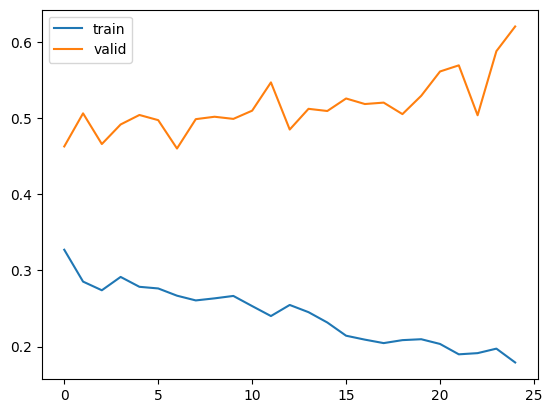

In [14]:
model3 = Sequential()
model3.add(LSTM(20, input_shape=(90, 4), return_sequences=True))
model3.add(Conv1D(filters = 1, kernel_size=1))
model3.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True)
, optimizer='adam')

history = model3.fit(x_train3, y_train3, validation_data=(x_valid3, y_valid3), epochs=25, batch_size=16, verbose=2)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show()

Визуализация слоев модели.

In [15]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 13.5 MB/s eta 0:00:00


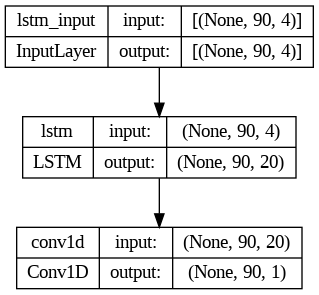

In [16]:
from keras.utils.vis_utils import plot_model
plot_model(model3, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Метрики:

In [17]:
y_pred3 = model3.predict(x_test3)
y_pred_n3 = np.transpose(y_pred3, (2,0,1))
print_metrics(y_test3, y_pred_n3)

351/351 [==============================] - 7s 15ms/step
accuracy = 0.9052048035194104
precision = 0.7931178672826531
recall = 0.7935391291223532


Визуализация вероятностей.

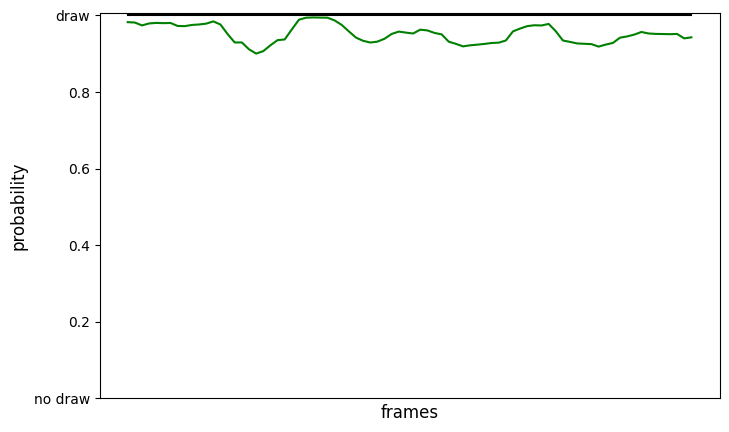

In [60]:
draw_plot(2150, y_test3, y_pred_n3)

Модель для детектирования тактических действий для 2 секнуд.

In [18]:
x_train2, y_train2 = data_creating(2, train)
x_test2, y_test2 = data_creating(2, test)

valid_shape = x_train2.shape[0] - int(x_train2.shape[0]*0.2)
x_valid2 = x_train2[valid_shape:]
y_valid2 = y_train2[valid_shape:]

x_train2, y_train2 = x_train2[:valid_shape], y_train2[:valid_shape]

In [20]:
model2 = Sequential()
model2.add(LSTM(20, input_shape=(60, 4), return_sequences=True))
model2.add(Conv1D(filters = 1, kernel_size=1))
model2.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam')
model2.fit(x_train2, y_train2, validation_data=(x_valid2, y_valid2), epochs=25, batch_size=32, verbose=2)

Epoch 1/25
625/625 - 23s - loss: 0.4068 - val_loss: 0.4870 - 23s/epoch - 37ms/step
Epoch 2/25
625/625 - 20s - loss: 0.3391 - val_loss: 0.5062 - 20s/epoch - 32ms/step
Epoch 3/25
625/625 - 18s - loss: 0.3150 - val_loss: 0.5043 - 18s/epoch - 29ms/step
Epoch 4/25
625/625 - 18s - loss: 0.2962 - val_loss: 0.5301 - 18s/epoch - 29ms/step
Epoch 5/25
625/625 - 19s - loss: 0.2820 - val_loss: 0.4918 - 19s/epoch - 30ms/step
Epoch 6/25
625/625 - 18s - loss: 0.2703 - val_loss: 0.5490 - 18s/epoch - 29ms/step
Epoch 7/25
625/625 - 19s - loss: 0.2617 - val_loss: 0.5320 - 19s/epoch - 31ms/step
Epoch 8/25
625/625 - 18s - loss: 0.2503 - val_loss: 0.5405 - 18s/epoch - 29ms/step
Epoch 9/25
625/625 - 20s - loss: 0.2463 - val_loss: 0.5544 - 20s/epoch - 32ms/step
Epoch 10/25
625/625 - 20s - loss: 0.2655 - val_loss: 0.5319 - 20s/epoch - 32ms/step
Epoch 11/25
625/625 - 19s - loss: 0.2633 - val_loss: 0.5053 - 19s/epoch - 30ms/step
Epoch 12/25
625/625 - 18s - loss: 0.2680 - val_loss: 0.5201 - 18s/epoch - 28ms/step
E

Метрики:

In [21]:
y_pred2 = model2.predict(x_test2)
y_pred_n2 = np.transpose(y_pred2, (2,0,1))
print_metrics(y_test2, y_pred_n2)

381/381 [==============================] - 4s 9ms/step
accuracy = 0.8571285800339521
precision = 0.7534219491118431
recall = 0.7341232862950818


Модель для детектирования тактических действий для 0.5 секнуд.

In [29]:
x_train0, y_train0 = data_creating(0.5, train)
x_test0, y_test0 = data_creating(0.5, test)

In [30]:
valid_shape = x_train0.shape[0] - int(x_train3.shape[0]*0.15)
x_valid0 = x_train0[valid_shape:]
y_valid0 = y_train0[valid_shape:]

x_train0, y_train0 = x_train0[:valid_shape], y_train0[:valid_shape]

In [31]:
model0 = Sequential()
model0.add(LSTM(20, input_shape=(15, 4), return_sequences=True))
model0.add(Conv1D(filters = 1, kernel_size=1))
model0.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam')
model0.fit(x_train0, y_train0, validation_data=(x_valid0, y_valid0), epochs=25, batch_size=32, verbose=2)

Epoch 1/25
811/811 - 12s - loss: 0.4879 - val_loss: 0.6932 - 12s/epoch - 15ms/step
Epoch 2/25
811/811 - 8s - loss: 0.4349 - val_loss: 0.6829 - 8s/epoch - 10ms/step
Epoch 3/25
811/811 - 8s - loss: 0.4203 - val_loss: 0.6954 - 8s/epoch - 10ms/step
Epoch 4/25
811/811 - 8s - loss: 0.4119 - val_loss: 0.6961 - 8s/epoch - 10ms/step
Epoch 5/25
811/811 - 9s - loss: 0.4058 - val_loss: 0.7170 - 9s/epoch - 11ms/step
Epoch 6/25
811/811 - 8s - loss: 0.4000 - val_loss: 0.6574 - 8s/epoch - 10ms/step
Epoch 7/25
811/811 - 8s - loss: 0.3951 - val_loss: 0.6908 - 8s/epoch - 10ms/step
Epoch 8/25
811/811 - 9s - loss: 0.3898 - val_loss: 0.7439 - 9s/epoch - 11ms/step
Epoch 9/25
811/811 - 8s - loss: 0.3851 - val_loss: 0.7018 - 8s/epoch - 10ms/step
Epoch 10/25
811/811 - 9s - loss: 0.3808 - val_loss: 0.7347 - 9s/epoch - 11ms/step
Epoch 11/25
811/811 - 9s - loss: 0.3765 - val_loss: 0.6774 - 9s/epoch - 11ms/step
Epoch 12/25
811/811 - 8s - loss: 0.3719 - val_loss: 0.7322 - 8s/epoch - 9ms/step
Epoch 13/25
811/811 - 9s

Метрики:

In [32]:
y_pred0 = model0.predict(x_test0)
y_pred_n0 = np.transpose(y_pred0, (2,0,1))
print_metrics(y_test0, y_pred_n0)

426/426 [==============================] - 2s 4ms/step
accuracy = 0.8300866754811224
precision = 0.7990612842750349
recall = 0.7756426712987974


Модель для детектирования тактических действий для 5 секнуд.

In [33]:
x_train5, y_train5 = data_creating(5, train)
x_test5, y_test5 = data_creating(5, test)

In [34]:
valid_shape = x_train5.shape[0] - int(x_train5.shape[0]*0.15)
x_valid5 = x_train5[valid_shape:]
y_valid5 = y_train5[valid_shape:]

x_train5, y_train5 = x_train5[:valid_shape], y_train5[:valid_shape]

In [35]:
model5 = Sequential()
model5.add(LSTM(20, input_shape=(150, 4), return_sequences=True))
model5.add(Conv1D(filters = 1, kernel_size=1))
model5.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam')
model5.fit(x_train5, y_train5, validation_data=(x_valid5, y_valid5), epochs=25, batch_size=32, verbose=2)

Epoch 1/25
463/463 - 35s - loss: 0.2984 - val_loss: 0.3908 - 35s/epoch - 75ms/step
Epoch 2/25
463/463 - 32s - loss: 0.2379 - val_loss: 0.4095 - 32s/epoch - 69ms/step
Epoch 3/25
463/463 - 31s - loss: 0.2540 - val_loss: 0.4129 - 31s/epoch - 66ms/step
Epoch 4/25
463/463 - 31s - loss: 0.2310 - val_loss: 0.3873 - 31s/epoch - 68ms/step
Epoch 5/25
463/463 - 32s - loss: 0.2140 - val_loss: 0.4373 - 32s/epoch - 69ms/step
Epoch 6/25
463/463 - 31s - loss: 0.2297 - val_loss: 0.3611 - 31s/epoch - 67ms/step
Epoch 7/25
463/463 - 31s - loss: 0.2196 - val_loss: 0.3722 - 31s/epoch - 66ms/step
Epoch 8/25
463/463 - 30s - loss: 0.2183 - val_loss: 0.3813 - 30s/epoch - 65ms/step
Epoch 9/25
463/463 - 31s - loss: 0.2120 - val_loss: 0.4021 - 31s/epoch - 67ms/step
Epoch 10/25
463/463 - 30s - loss: 0.2106 - val_loss: 0.4134 - 30s/epoch - 65ms/step
Epoch 11/25
463/463 - 30s - loss: 0.2097 - val_loss: 0.4034 - 30s/epoch - 65ms/step
Epoch 12/25
463/463 - 31s - loss: 0.2203 - val_loss: 0.3932 - 31s/epoch - 67ms/step
E

Метрики:

In [36]:
y_pred5 = model5.predict(x_test5)
y_pred_n5 = np.transpose(y_pred5, (2,0,1))
print_metrics(y_test5, y_pred_n5)

291/291 [==============================] - 7s 21ms/step
accuracy = 0.9020608277741913
precision = 0.7669818601763421
recall = 0.7760268137876499
